# PODEM ALGORITHM

- Author : Aditya Warnulkar
- Email : warnulka@usc.edu

The purpose of this notebook is to implement PODEM algorithm for combo logic

In [872]:
ckt_file_name = "../golden_files/c17/test_case_1/c17.ckt"; circuit_name = 'C17';
#ckt_file_name = "../golden_files/friedman/friedman.ckt"; circuit_name = 'Friedman';
#ckt_file_name = "../golden_files/c1355/c1355.ckt"; circuit_name = 'C1355';
#ckt_file_name = "../golden_files/c880/c880.ckt"; circuit_name = 'C880';
#ckt_file_name = "podem_debug.ckt"; circuit_name = 'PODEM_DEBUG';

fault_file_name = "../golden_files/c17/test_case_1/c17_fault_list.txt";
#fault_file_name = "../golden_files/friedman/friedman_fault_list.txt";
#fault_file_name = "../golden_files/c1355/c1355_small_fault_list.txt";
#fault_file_name = "../golden_files/c1355/c1355_fault_list.txt";
#fault_file_name = "../golden_files/c880/c880_fault_list.txt";
#fault_file_name = "podem_debug_fault_list.txt";

vector_file_name = "c17_podem_vectors.txt";
#vector_file_name = "friedman_podem_vectors.txt";
#vector_file_name = "c1355_podem_vectors.txt";
#vector_file_name = "c880_podem_vectors.txt";
#vector_file_name = "podem_debug_vectors.txt";

In [873]:
# Import Libraries
import numpy
import pandas as pd
import time
import matplotlib.pyplot as plt

## 5 valued truth tables for AND , OR , NOT , XOR

In [874]:
TRUTH_AND = numpy.array([[0,0,0,0,0],
                         [0,1,2,3,4],
                         [0,2,2,0,4],
                         [0,3,0,3,4],
                         [0,4,4,4,4]]);

TRUTH_OR = numpy.array([[0,1,2,3,4],
                         [1,1,1,1,1],
                         [2,1,2,1,4],
                         [3,1,1,3,4],
                         [4,1,4,4,4]]);

TRUTH_NOT = numpy.array([1,0,3,2,4]);

TRUTH_XOR = numpy.array([[0,1,2,3,4],
                         [1,0,3,2,4],
                         [2,3,0,1,4],
                         [3,2,1,0,4],
                         [4,4,4,4,4]]);

#LOGIC_DICT = {0:'0', 1:'1', 2:'D', 3:'Dbar', 4:'x'};
LOGIC_DICT = {0:'0', 1:'1', 2:'1', 3:'0', 4:'x'};

## Functions to implement 5 valued logic evaluation
Note: Below variables are global and can be accessed by any function that doesn't modify them

In [875]:
# Implementation of 5 values Logic functions

def AND(input_list):
    y = input_list[0];
    num_inputs = len(input_list);
    
    for i in range(1,len(input_list)):
        y = TRUTH_AND[y,input_list[i]];
    
    return y;

def OR(input_list):
    y = input_list[0];
    num_inputs = len(input_list);
    
    for i in range(1,len(input_list)):
        y = TRUTH_OR[y,input_list[i]];
    
    return y;

def NOT(input_value):
    return TRUTH_NOT[input_value];

def XOR(input_list):
    y = input_list[0];
    num_inputs = len(input_list);
    
    for i in range(1,len(input_list)):
        y = TRUTH_XOR[y,input_list[i]];
    
    return y;



## Define node class

In [876]:
# Define a node class
class Node:
    '''Common Base class for all the circuit nodes'''
    
    def __init__ (self,node_type=0,node_num=0,node_idx=0,gate_type=0,value=0,num_fout=0,num_fin=0):
        self.node_type = node_type;
        self.node_num = node_num;
        self.node_idx = node_idx;
        self.gate_type = gate_type;
        self.num_fout = num_fout;
        self.num_fin = num_fin;
        self.fin_list = list(); # Node idx of inputs to the gate
        self.unode_list = list(); #TODO: Isn't fin_list enough ?
        self.level = -1;
        self.value = 4; #Initialise the node to 'x'
        self.c = -1; # Controlling value
        self.ip = -1; # Inversion Parity



## Parser implementation

In [877]:
# GATE dictionary
gate_dict = dict();
gate_dict[0] = 'IPT';
gate_dict[1] = 'BRCH';
gate_dict[2] = 'XOR';
gate_dict[3] = 'OR';
gate_dict[4] = 'NOR';
gate_dict[5] = 'NOT';
gate_dict[6] = 'NAND';
gate_dict[7] = 'AND';

#print gate_dict

# Node type dictionary
node_type_dict = dict();
node_type_dict[0] = 'GATE';
node_type_dict[1] = 'PI';
node_type_dict[2] = 'BRCH';
node_type_dict[3] = 'PO';

#print node_type_dict

def parser(ckt_file_name):
    
    ckt_file = open(ckt_file_name,'r');
    node_list = [];
    count = 0;
    node_dict = {}; # Mapping of num -> idx

    for line in ckt_file:

        line_list = line.split();
        line_list = map(int,line_list);

        # Unpack node attributes
        node_type = line_list[0];
        node_num  = line_list[1];
        gate_type = line_list[2];
        num_fout  = line_list[3];

        # Map node_num to idx
        node_dict[node_num] = count;

        # Create node instance
        node = Node(node_type=node_type,node_num=node_num,node_idx=count,gate_type=gate_type,num_fout=num_fout);

        #node.fin_list = list(); #TODO : can this be done in constructor ??

        if ((node_type == 0) or (node_type == 3)) : #GATE or PO
            node.num_fin = line_list[4];
            for x in range(0,node.num_fin):
                node.fin_list.append(line_list[x+5]);
        elif (node_type == 2): # BRCH
            node.fin_list.append(line_list[3]); #TODO: for BRCH num_fout exist . Does it mean something ?
        elif (node_type == 1): #PI
            node.num_fin = 0;

        # Assign controling values and ip(TODO: Combine the below conditions)
        if(gate_type == 1): #BRCH
            node.ip = 0;
        elif(gate_type == 3): #OR
            node.c = 1;
            node.ip = 0;
        elif(gate_type == 4): #NOR
            node.c = 1;
            node.ip = 1;
        elif(gate_type == 5): #NOT
            node.ip = 1;
        elif(gate_type == 6): #NAND
            node.c = 0;
            node.ip = 1;
        elif(gate_type == 7): #AND
            node.c = 0;
            node.ip = 0;

        # Push the node object into node_list array
        node_list.append(node);
        count = count + 1;
    
    ckt_file.close();
    return (node_list,node_dict);

# Update up-node list
def update_unode():
    
    """This functions find the indx of all the fin's of a node and store it in unode_list"""
    
    for np in node_list:
        if(np.node_type != 1):
            np.unode_list = [node_dict[x] for x in np.fin_list];
            


## Levelization Implementation

In [878]:
# Levelization
def lev(node_list):
    
    """This function accepts node_list and assigns level to each node"""
    
    node_count = len(node_list);
    print 'Number of Nodes is {}'.format(node_count);
    
    # Assign level 0 to all PI
    num_pi = 0;
    for np in node_list:
        if(np.node_type == 1): #PI
            np.level = 0;
            num_pi = num_pi + 1;
    
    print 'Number of PI is {}'.format(num_pi);
    
    ulevel_count = len(node_list) - num_pi;
    
    while(ulevel_count>0):
        for np in node_list:
            if (np.node_type != 1):
                in_level = [node_list[x].level for x in np.unode_list];
                in_level = numpy.array(in_level);
                if (numpy.sum(in_level==-1) == 0):
                    np.level = numpy.max(in_level) + 1;
    
        ulevel_list = [node_list[x].level for x in range(0,len(node_list))];
        ulevel_list = numpy.array(ulevel_list);
        ulevel_count = numpy.sum(ulevel_list==-1);


## PC implementation

In [879]:
# Print circuit description (after parsing)
def pc(node_list):
    
    """This function print the circuit description"""
    
    node_type_list = list();
    node_idx_list = list();
    node_number_list = list();
    num_fout_list = list();
    num_fin_list = list();
    node_fin_list = list();
    node_level_list = list();
    node_value_list = list();
    node_c_list = list();
    node_ip_list = list();
    
    for np in node_list:
        
        node_idx_list.append(np.node_idx);
        num_fout_list.append(np.num_fout);
        num_fin_list.append(len(np.fin_list));
        node_number_list.append(np.node_num);
        node_level_list.append(np.level);
        node_value_list.append(np.value);
        node_c_list.append(np.c);
        node_ip_list.append(np.ip);
        
        if (np.node_type == 0): #GATE
            node_type_list.append(gate_dict[np.gate_type]);
            node_fin_list.append([','.join(map(str,np.unode_list))]);
        elif(np.node_type == 1): #PI
            node_type_list.append(gate_dict[np.gate_type]);
            node_fin_list.append(['-']);
        elif(np.node_type == 2): #BRCH
            node_type_list.append(gate_dict[np.gate_type]);
            node_fin_list.append([','.join(map(str,np.unode_list))]);
        elif(np.node_type == 3): #PO
            node_type_list.append(node_type_dict[np.node_type]);
            node_fin_list.append([','.join(map(str,np.unode_list))]);

    # Display circuit dataframe
    d = {'INDX':node_idx_list,
         'NODE_TYPE':node_type_list,
         'NODE_NUM':node_number_list,
         'NUM_FOUT':num_fout_list,
         'NUM_FIN':num_fin_list,
         'FIN_INDX':node_fin_list,
         'LEVEL':node_level_list,
         'VALUE':node_value_list,
         'C_VALUE':node_c_list,
         'INV_PARITY':node_ip_list}
    
    df = pd.DataFrame(data=d,columns=['INDX','NODE_TYPE','NODE_NUM','NUM_FOUT','NUM_FIN','FIN_INDX','LEVEL','VALUE','C_VALUE','INV_PARITY']);
    
    return df;


## Parse , Levelize and Print circuit description
- Note: All the node values are initialized to 'x'

In [880]:
(node_list,node_dict) = parser(ckt_file_name);
update_unode();
lev(node_list);
df = pc(node_list);
print df

Number of Nodes is 17
Number of PI is 5
    INDX NODE_TYPE  NODE_NUM  NUM_FOUT  NUM_FIN FIN_INDX  LEVEL  VALUE  \
0      0       IPT         1         1        0      [-]      0      4   
1      1       IPT         2         1        0      [-]      0      4   
2      2       IPT         3         2        0      [-]      0      4   
3      3      BRCH         8         3        1      [2]      1      4   
4      4      BRCH         9         3        1      [2]      1      4   
5      5       IPT         6         1        0      [-]      0      4   
6      6       IPT         7         1        0      [-]      0      4   
7      7      NAND        10         1        2    [0,3]      2      4   
8      8      NAND        11         2        2    [4,5]      2      4   
9      9      BRCH        14        11        1      [8]      3      4   
10    10      BRCH        15        11        1      [8]      3      4   
11    11      NAND        16         2        2    [1,9]      4      4  

# Implementing PODEM related functions

## Error at PO , test_not_possible

In [881]:
# Error at PO implementation
#TODO: is it necessary to pass node_list ??
def error_at_PO():
    flag = 0;
    for np in node_list:
        if(np.node_type == 3): #PO
            if (np.value == 2 or np.value == 3):
                flag = 1;
    
    return flag;


## test_not_possible
This occurs when either of the condition applies
- The target fault l s-a-v cannot be activated , since line l has value v
- No error can be propogated to PO , either because D_FRONTIER is empty or because the error propogation look ahead shows that it will become empty

In [882]:
# test_not_possible implementation
#TODO: is it necessary to pass node_list ??
def test_not_possible():
    
    global test_np_count;
    # check if line l has value v (fault cannot be activated)
    if(node_list[fault_idx].value == fault_type):
        condition_1 = True;
    else:
        condition_1 = False;
        
    # Check if D frontier is empty
    if(len(D_FRONTIER) == 0):
        condition_2 = True;
    else:
        condition_2 = False;
        
    # Check if line l is x
    if(node_list[fault_idx].value == 4):
        condition_3 = True;
    else:
        condition_3 = False;
    
    if(test_np_count > 2*npi):
        condition_4 = 1;
    else:
        condition_4 = 0;
    
    if(condition_1 or condition_4 or (condition_2 and not(condition_3))):
        test_np_count = test_np_count + 1;
        return 1;
    else:
        return 0;


## Objective
- Objective doesn't accept any arguments
- Objective returns the node_idx and the value to be set
- (obj_idx , obj_value) = OBJECTIVE()

In [883]:
def OBJECTIVE():
    
    # Set the fault if its not set
    if (node_list[fault_idx].value == 4): # value of l is 'x'
        if (fault_type == 1): # S-A-1 fault
            node_list[fault_idx].value = 3; # D_bar
            obj_value = 0;
        else: # S-A-0 fault
            node_list[fault_idx].value = 2; # D
            obj_value = 1;
        return (fault_idx,obj_value);
    
    # Select a Gate (G) from D-Frontier
    dfront = D_FRONTIER[0];
    #print 'Gate choice from D_front is {}'.format(dfront);
    
    # Select an input j of G with value 'x'
    for x in node_list[dfront].unode_list:
        if(node_list[x].value == 4):
            return(x , int(not(node_list[dfront].c)));
    
    print 'ERROR..!!! I shouldnt be here\n';
    print 'Objective called when D-Frontier is empty\n';
    

## Backtrace
- Backtrace takes the ojective and figures out the PI assignment that satifies the objective
- Loop until node k is NOT PI
- Select a input of k with value 'x'
- k = j , v = v xor i

In [884]:
def BACKTRACE_GATE_NOT_BRCH (idx,val,ip):
    '''This function returns input node and its value inorder to achive objective'''
    
    # Loop through all the inputs of the gate
    if(try_reverse == 0):
        for x in node_list[idx].unode_list:
            if(node_list[x].value == 4): #'x'
                return (node_list[x].node_idx,val^ip);
    else:
        for x in reversed(node_list[idx].unode_list):
            if(node_list[x].value == 4): #'x'
                return (node_list[x].node_idx,val^ip);
    
    print 'Didnt find an input which is x :-( ';


def BACKTRACE (k , vk):
    
    v = vk;
    
    while (node_list[k].node_type != 1):
        
        if(node_list[k].gate_type == 2): #XOR
            print 'TODO: NOT YET IMPLEMENTED';
        else: #All other node types
            i = node_list[k].ip;
            (k,v) = BACKTRACE_GATE_NOT_BRCH(idx=k,val=v,ip=i);
    
    # k is PI
    return (k,v);

## 5 valued logic_simulation

In [885]:
def logic_simulation():
    
    """This function implements simple_logic_simulation"""
    
    #TODO: Error checking if length of vector != number of PIs
    
    # Apply input vector to all primary inputs
    
    max_level = max([node_list[x].level for x in range(0,len(node_list))]); #TODO: Why repeat this for each vector?
    
    # Note unlike regular logic_simulation , the loop starts from level 0
    for l in range(0,max_level+1):
        for np in node_list:
            if(np.level == l): #Do not process faulty node. Retain its value
                
                # Assign appropriate value to the node
                if(np.gate_type == 1): #BRCH
                    np.value = node_list[np.unode_list[0]].value;
                elif(np.gate_type == 2): #XOR
                    inputs = [node_list[x].value for x in np.unode_list];
                    np.value = XOR(inputs);
                elif(np.gate_type == 3): #OR
                    inputs = [node_list[x].value for x in np.unode_list];
                    np.value = OR(inputs);
                elif(np.gate_type == 4): #NOR
                    inputs = [node_list[x].value for x in np.unode_list];
                    np.value = NOT(OR(inputs));
                elif(np.gate_type == 5): #NOT
                    np.value = NOT(node_list[np.unode_list[0]].value);
                elif(np.gate_type == 6): #NAND
                    inputs = [node_list[x].value for x in np.unode_list];
                    np.value = NOT(AND(inputs));
                elif(np.gate_type == 7): #AND
                    inputs = [node_list[x].value for x in np.unode_list];
                    np.value = AND(inputs);
                
                # Process fault node
                if (np.node_idx == fault_idx):
                    if(np.value == int(not(fault_type))):
                        if(fault_type == 0): #SA0
                            np.value = 2; #D
                        else: #SA1
                            np.value = 3; #D_bar



## Imply
- Imply takes the arguments returned by backtrace
- It will perform 5 valued logic simulation with those values
- Note : Imply should NOT touch the node which has fault. It should be left as it is (D or D_bar)

In [886]:
def IMPLY(idx,val):
    
    '''This function assigns the value returned by backtrace and performs 5 valued logic simulation'''
    
    #print ('IMPLY : {} ; {}'.format(idx,val)); #debug
    log_file.write ('IMPLY : {} ; {} ; '.format(idx,val)); #debug
    # Assing value returned by backtrace
    if(fault_idx != idx):
        node_list[idx].value = val;
    
    # Perform 5 valued logic simulation
    logic_simulation();


## Update D Frontier

In [887]:
def IS_D_FRONTIER(idx):
    '''Input : idx of the gate output'''
    
    # Check if node is 'x'
    if(node_list[idx].value != 4):
        return 0; #FAILURE
    else:
        for x in node_list[idx].unode_list:
            if((node_list[x].value == 2) or (node_list[x].value == 3)):
                return 1; #SUCCESS


def update_D_frontier():
    
    '''This functions searched for new D-Frontier after imply and updates them'''
    
    # Clear all enteries in D-Frontier
    D_FRONTIER[:] = [];
    
    for np in node_list:
        if((np.gate_type != 0) and (np.gate_type != 1)): #no PI , BRCH
            if(IS_D_FRONTIER(np.node_idx)):
                D_FRONTIER.append(np.node_idx);

        

## PODEM function implementation

In [888]:
def PODEM():
    
    global podem_count;
    podem_count = podem_count + 1;
    #print ('\nPODEM Iteration is {}'.format(podem_count)); #debug
    log_file.write ('\nPODEM Iteration is {} ; '.format(podem_count)); #debug
    
    #print ('error_at_PO {}'.format(error_at_PO())); #debug
    log_file.write ('error_at_PO {} ; '.format(error_at_PO())); #debug
    if (error_at_PO()):
        return 1; #SUCCESS
    
    #print ('test_not_possible {}'.format(test_not_possible())); #debug
    log_file.write ('test_not_possible {} ; '.format(test_not_possible())); #debug
    if (test_not_possible()):
        return 0; #FAILURE
    
    # Call objective
    (obj_idx,obj_value) = OBJECTIVE();
    #print ('OBJECTIVE: {} ; {}'.format(obj_idx,obj_value)); #debug
    log_file.write ('OBJECTIVE: {} ; {} ; '.format(obj_idx,obj_value)); #debug
    
    # Backtrace objective to find PI assignment
    (pi_idx,pi_value) = BACKTRACE(obj_idx,obj_value);
    #print ('BACKTRACE: {} ; {}'.format(pi_idx,pi_value)); #debug
    log_file.write ('BACKTRACE: {} ; {} ; '.format(pi_idx,pi_value)); #debug
    
    # Imply the PI assignment
    IMPLY(pi_idx,pi_value);
    
    # Update D Frontier
    update_D_frontier();
    #print ('D_FRONTIER : {}'.format(D_FRONTIER)); #debug
    log_file.write ('D_FRONTIER : {} ; '.format(D_FRONTIER)); #debug
    
    if(PODEM()):
        return 1;
    
    # Reverse Decision
    IMPLY(pi_idx,int(not(pi_value)));
    
    # Update D Frontier
    update_D_frontier();
    #print ('D_FRONTIER : {}'.format(D_FRONTIER)); #debug
    log_file.write ('D_FRONTIER : {} ; '.format(D_FRONTIER)); #debug
    
    if(PODEM()):
        return 1;
    
    IMPLY(pi_idx,4);
    
    # Update D Frontier
    update_D_frontier();
    #print ('D_FRONTIER : {}'.format(D_FRONTIER)); #debug
    log_file.write ('D_FRONTIER : {} ; '.format(D_FRONTIER)); #debug
    
    return 0; #FAILURE

def print_test_vector(node_list):
    test_vector = list();
    for np in node_list:
        if(np.node_type == 1): #PI
            #print 'IDX is {} ; Value is {}'.format(np.node_idx,np.value);
            test_vector.append(np.value);
    
    test_vector = [LOGIC_DICT[x] for x in test_vector];
    test_vector = ''.join(test_vector);
    
    print ('Fault is {} ; Test Vector is {}\n'.format(fault,test_vector));
    log_file.write ('Fault is {} ; Test Vector is {}\n'.format(fault,test_vector));
    vector_file.write('Fault is {} ; Test Vector is {}\n'.format(fault,test_vector));




# PODEM (main code for single fault)
**Note** : parsing and levelization is already done above

# Podem (main code for full fault list)

In [889]:
fault_file = open(fault_file_name,'r');
vector_file = open(vector_file_name,'w');
log_file = open('debug_log.txt','w');

# Global Variables
fault = 0;
fault_idx = 0;
fault_type = 0;
D_FRONTIER = list();

# Count the number of PI
npi = 0;
for np in node_list:
    if(np.node_type == 1):
        npi = npi + 1;

time_elapsed = list();
# Parse through all the faults in fault_file
for line in fault_file:
    
    start_time = time.time();
    # Extract line
    line = line.rstrip('\n');
    line = line.split();
    
    # Initialise fault
    fault = map(int,line);
    fault = fault[0];
    #print 'Fault is {}'.format(fault);
    
    # Decode fault
    fault_idx = int(fault/10);
    fault_type = fault % 10;
    
    # Reset all node values to 'x';
    for np in node_list:
        np.value = 4;
    
    # Empty D-Frontier from previous loop
    D_FRONTIER[:] = [];
    
    test_np_count = 0;
    try_reverse = 0;
    podem_forward_result = 0;
    podem_backward_result = 0;
    
    # Run PODEM
    podem_count = 0;
    podem_forward_result = PODEM();
    
    if(podem_forward_result == 0):
        try_reverse = 1;
        for np in node_list:
            np.value = 4;
        podem_count = 0;
        test_np_count = 0;
        D_FRONTIER[:] = [];
        podem_backward_result = PODEM();
        
    end_time = time.time();
    time_elapsed.append(end_time - start_time);

    podem_result = podem_forward_result or podem_backward_result;
    
    if(podem_result == 1):
        print_test_vector(node_list);
    else:
        print 'Fault {} cannot be detected\n'.format(fault);
        vector_file.write('Fault {} cannot be detected ; test_np_count {}\n'.format(fault,test_np_count));

print ('Total Time Elapsed : {:4f} seconds'.format(sum(time_elapsed)));
fault_file.close();
log_file.close();
vector_file.close();

Fault is 0 ; Test Vector is 101xx

Fault is 1 ; Test Vector is 001xx

Fault is 10 ; Test Vector is x10xx

Fault is 11 ; Test Vector is x00xx

Fault is 20 ; Test Vector is 11111

Fault is 21 ; Test Vector is 11011

Fault is 30 ; Test Vector is 101xx

Fault is 31 ; Test Vector is 100xx

Fault is 40 ; Test Vector is x1111

Fault is 41 ; Test Vector is x101x

Fault is 50 ; Test Vector is x1111

Fault is 51 ; Test Vector is x1101

Fault is 60 ; Test Vector is x00x1

Fault is 61 ; Test Vector is x00x0

Fault is 70 ; Test Vector is 00xxx

Fault is 71 ; Test Vector is 101xx

Fault is 80 ; Test Vector is x10xx

Fault is 81 ; Test Vector is x1111

Fault is 90 ; Test Vector is x10xx

Fault is 91 ; Test Vector is x111x

Fault is 100 ; Test Vector is x00x1

Fault is 101 ; Test Vector is xx111

Fault is 110 ; Test Vector is 00xxx

Fault is 111 ; Test Vector is x10xx

Fault is 120 ; Test Vector is 00xxx

Fault is 121 ; Test Vector is x10xx

Fault is 130 ; Test Vector is x011x

Fault is 131 ; Test Vec

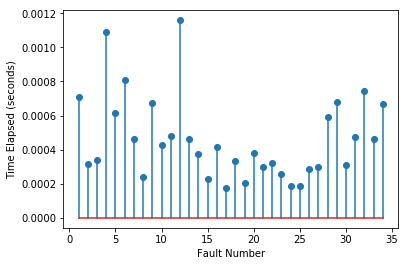

In [890]:
x = numpy.arange(1,len(time_elapsed)+1);
time_elapsed = numpy.array(time_elapsed);
plt.stem(x,time_elapsed);
plt.xlabel('Fault Number');
plt.ylabel('Time Elapsed (seconds)');
#plt.title(circuit_name)
plt.show();